In [ ]:
import marimo as mo

# Model Training and Evaluation

This notebook covers:
1. **Evaluation Metric**: Defining Accuracy.
2. **Baseline Model**: Training a Logistic Regression model on flattened audio features.
3. **Advanced Classical**: MFCCs + MelSpectrogram + SVM/XGBoost.
4. **Transfer Learning**: PyTorch YAMNet embeddings + SVM.
5. **Data Augmentation**: Setup for deep learning.
6. **Fine-Tuning**: Fine-tuning `facebook/wav2vec2-base` using Hugging Face Trainer.

In [ ]:
import datasets
from datasets import load_from_disk
import numpy as np
import os
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import transformers
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer
import evaluate
import dotenv
from huggingface_hub import login
import torchaudio
import torchaudio.transforms as T
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import random
import xgboost as xgb
import xgboost as xgb
from torch_vggish_yamnet import yamnet





# Ensure models directory exists
os.makedirs("models", exist_ok=True)

In [ ]:
dotenv.load_dotenv(dotenv.find_dotenv(usecwd=True))
HUGGING_FACE_PAT = os.environ.get("HUGGING_FACE_PAT")

In [ ]:
if HUGGING_FACE_PAT:
    login(token=HUGGING_FACE_PAT)

## 1. Load Data

In [ ]:
DATA_PATH = "data/baby_cry_16k"
dataset = load_from_disk(DATA_PATH)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 1050
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 263
    })
})


## 2. Baseline Model: Logistic Regression

In [ ]:
# For baseline, we'll just flatten the audio arrays. 
# This is naive but works as a "random" or simple baseline check.
# Note: Audio lengths must be uniform for this to work easily with sklearn without padding.
# If lengths vary, we might need to truncate/pad or extract features (like mean amplitude).

# Let's use a simple feature: Mean Amplitude & Std Dev per sample
def extract_simple_features(batch):
    audio_arrays = [x["array"] for x in batch["audio"]]
    features = []
    for audio in audio_arrays:
        features.append([np.mean(audio), np.std(audio), np.max(audio), np.min(audio)])
    return {"features": features, "labels": batch["label"]}

train_simple = dataset["train"].map(extract_simple_features, batched=True)
test_simple = dataset["test"].map(extract_simple_features, batched=True)

X_train_baseline = np.array(train_simple["features"])
y_train_baseline = np.array(train_simple["labels"])
X_test_baseline = np.array(test_simple["features"])
y_test = np.array(test_simple["labels"])

print(f"Train features shape: {X_train_baseline.shape}")

Train features shape: (1050, 4)


In [ ]:
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_baseline, y_train_baseline)

y_pred = clf.predict(X_test_baseline)
acc = accuracy_score(y_test, y_pred)

print(f"Baseline Logistic Regression Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Baseline Logistic Regression Accuracy: 0.2662

Classification Report:


/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        27
           4       0.29      0.91      0.43        76
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00        22
           7       0.06      0.05      0.05        22
           8       0.00      0.00      0.00        26

    accuracy                           0.27       263
   macro avg       0.04      0.11      0.05       263
weighted avg       0.09      0.27      0.13       263



## 3. Advanced Classical ML: MFCCs + MelSpectrogram + SVM/XGBoost

Using Torchaudio to extract:
- MFCCs (40)
- Mel Spectrogram (128)

Models:
- SVM (RBF Kernel)
- XGBoost

In [ ]:
# Function to extract advanced features using Torchaudio only
# (Librosa unavailable on Py3.13)
def extract_advanced_features(batch):
    audio_arrays = [x["array"] for x in batch["audio"]]
    sr = 16000

    # Define transforms
    # 1. MFCC
    mfcc_transform = T.MFCC(
        sample_rate=sr,
        n_mfcc=40,
        melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 64, "center": False}
    )

    # 2. MelSpectrogram (128 bins)
    mel_transform = T.MelSpectrogram(
        sample_rate=sr,
        n_fft=400,
        hop_length=160,
        n_mels=128,
        center=False
    )

    features = []
    for y in audio_arrays:
        y_tensor = torch.tensor(y, dtype=torch.float32)

        # Extract MFCC
        mfcc = mfcc_transform(y_tensor)
        mfcc_mean = torch.mean(mfcc, dim=1).numpy()
        mfcc_std = torch.std(mfcc, dim=1).numpy()

        # Extract Mel Spectrogram
        melspec = mel_transform(y_tensor)
        # Convert to log scale (dB) roughly: log(x + eps)
        melspec_db = torch.log(melspec + 1e-9)
        mel_mean = torch.mean(melspec_db, dim=1).numpy()
        mel_std = torch.std(melspec_db, dim=1).numpy()

        # Concatenate: 40*2 + 128*2 = 80 + 256 = 336 features
        features.append(np.concatenate([mfcc_mean, mfcc_std, mel_mean, mel_std]))

    return {"advanced_features": features, "labels": batch["label"]}

print("Extracting Advanced Features (MFCC + MelSpectrogram)...")
train_feat = dataset["train"].map(extract_advanced_features, batched=True, batch_size=100)
test_feat = dataset["test"].map(extract_advanced_features, batched=True, batch_size=100)

X_train_advanced = np.array(train_feat["advanced_features"])
y_train_advanced = np.array(train_feat["labels"])
X_test_advanced = np.array(test_feat["advanced_features"])
y_test_advanced = np.array(test_feat["labels"])

print(f"Advanced Feature Matrix Shape: {X_train_advanced.shape}")

Extracting Advanced Features (MFCC + MelSpectrogram)...
Advanced Feature Matrix Shape: (1050, 336)


In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_advanced)
X_test_scaled = scaler.transform(X_test_advanced)

# Train SVM
clf_svc = SVC(kernel='rbf', C=1.0, random_state=42)
clf_svc.fit(X_train_scaled, y_train_advanced)

y_pred_svc = clf_svc.predict(X_test_scaled)
acc_svc = accuracy_score(y_test_advanced, y_pred_svc)

print(f"MFCC + SVM Accuracy: {acc_svc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svc))

MFCC + SVM Accuracy: 0.5894

Classification Report:


/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        25
           1       1.00      0.33      0.50        21
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        27
           4       0.42      1.00      0.59        76
           5       0.88      1.00      0.94        22
           6       0.95      0.91      0.93        22
           7       1.00      1.00      1.00        22
           8       0.00      0.00      0.00        26

    accuracy                           0.59       263
   macro avg       0.58      0.51      0.49       263
weighted avg       0.53      0.59      0.50       263



In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf_svc, X_train_scaled, y_train_advanced, cv=cv, scoring='accuracy')
print(f"5-Fold CV Accuracy (SVM): {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

5-Fold CV Accuracy (SVM): 0.5857 (+/- 0.0124)


In [ ]:
# Train XGBoost
# XGBoost can often handle unscaled data well, but since we have it let's try raw first
# (or we could use X_train_scaled)

xgb_clf = xgb.XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_clf.fit(X_train_advanced, y_train_advanced)

y_pred_xgb = xgb_clf.predict(X_test_advanced)
acc_xgb = accuracy_score(y_test_advanced, y_pred_xgb)

print(f"MFCC + XGBoost Accuracy: {acc_xgb:.4f}")
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:10:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


MFCC + XGBoost Accuracy: 0.3574

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.35      0.32      0.33        25
           1       0.39      0.33      0.36        21
           2       0.00      0.00      0.00        22
           3       0.06      0.04      0.04        27
           4       0.15      0.18      0.16        76
           5       0.96      1.00      0.98        22
           6       0.90      0.86      0.88        22
           7       1.00      1.00      1.00        22
           8       0.04      0.04      0.04        26

    accuracy                           0.36       263
   macro avg       0.43      0.42      0.42       263
weighted avg       0.36      0.36      0.36       263



## 4. YAMNet Embeddings (Transfer Learning) + SVM

Using **PyTorch** implementation of YAMNet to extract 1024-d embeddings.

In [ ]:
# Load PyTorch YAMNet
# Requires initializing and loading weights usually, but let's check if the package provides a helper.
# The package `torch_vggish_yamnet` likely has a `yamnet` function or class.
# We will assume: `model = torch_vggish_yamnet.yamnet(pretrained=True)` or similar.
# If not simple, we might need to download weights. 
# Let's try to instantiate it. 
# Based on package naming, likely `model = torch_vggish_yamnet.yamnet()`

yamnet_model = yamnet.yamnet(pretrained=True)
yamnet_model.eval()

yamnet_device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.backends.mps.is_available():
    yamnet_device = "mps"
yamnet_model.to(yamnet_device)

def extract_yamnet_embeddings(batch):
    audio_arrays = [x["array"] for x in batch["audio"]]
    embeddings_batch = []

    with torch.no_grad():
        for waveform in audio_arrays:
            # YAMNet expects float32 tensor
            waveform_tensor = torch.tensor(waveform, dtype=torch.float32).to(yamnet_device)
            # Reshape to (N,) - strict 1D
            if waveform_tensor.ndim > 1:
                 waveform_tensor = waveform_tensor.squeeze()

            # Model call
            # Returns: prediction, embedding, log_mel_spectrogram
            _, embedding = yamnet_model(waveform_tensor)
            print(out)

            # Embedding shape: (N_frames, 1024)
            # Average pooling
            avg_embedding = torch.mean(embedding, dim=0).cpu().numpy()
            embeddings_batch.append(avg_embedding)

    return {"yamnet_embeddings": embeddings_batch, "labels": batch["label"]}

print("\nExtracting PyTorch YAMNet Embeddings...")
train_yam = dataset["train"].map(extract_yamnet_embeddings, batched=True, batch_size=8)
test_yam = dataset["test"].map(extract_yamnet_embeddings, batched=True, batch_size=8)

X_train_yam = np.array(train_yam["yamnet_embeddings"])
y_train_yam = np.array(train_yam["labels"])
X_test_yam = np.array(test_yam["yamnet_embeddings"])

# Train SVM on YAMNet features
scaler_yam = StandardScaler()
X_train_yam_scaled = scaler_yam.fit_transform(X_train_yam)
X_test_yam_scaled = scaler_yam.transform(X_test_yam)

clf_yam = SVC(kernel='rbf', C=1.0, random_state=42)
clf_yam.fit(X_train_yam_scaled, y_train_yam)

y_pred_yam = clf_yam.predict(X_test_yam_scaled)
acc_yam = accuracy_score(y_test, y_pred_yam)

print(f"YAMNet Embeddings + SVM Accuracy: {acc_yam:.4f}")
print(classification_report(y_test, y_pred_yam))


Extracting PyTorch YAMNet Embeddings...


Map:   0%|                                                                                                                    | 0/1050 [00:00<?, ? examples/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 2)

In [ ]:
torch_vggish_yamnet

## 5. Data Augmentation Setup

In [ ]:
# Simple manual augmentation pipeline
def add_noise(waveform, noise_level=0.005):
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise

def random_gain(waveform, min_gain=0.8, max_gain=1.2):
    gain = random.uniform(min_gain, max_gain)
    return waveform * gain

def apply_augmentation_pipeline(waveform):
    if random.random() < 0.5:
        waveform = add_noise(waveform)
    if random.random() < 0.5:
        waveform = random_gain(waveform)
    return waveform

print("Augmentation functions ready.")

Augmentation functions ready.


## 6. Fine-Tune Wav2Vec2

In [ ]:
# Wav2Vec2 Feature Extractor
# We need to map labels to ids
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

print(f"Labels: {labels}")

Labels: ['belly pain', 'burping', 'cold_hot', 'discomfort', 'hungry', 'laugh', 'noise', 'silence', 'tired']


In [ ]:
MODEL_CHECKPOINT = "facebook/wav2vec2-base"
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)

max_duration = 5.0 # seconds
sampling_rate = 16000
max_length = int(max_duration * sampling_rate)

def preprocess_function(examples, augment=False):
    audio_arrays = [x["array"] for x in examples["audio"]]

    # Apply augmentation if requested
    if augment:
        # Convert to tensor, augment, back to numpy for feature extractor
        augmented_arrays = []
        for y in audio_arrays:
            y_tensor = torch.tensor(y, dtype=torch.float32)
            y_aug = apply_augmentation_pipeline(y_tensor)
            augmented_arrays.append(y_aug.numpy())
        audio_arrays = augmented_arrays

    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=max_length, 
        truncation=True,
        padding=True
    )
    return inputs

# Prepare Train (with augmentation) and Test (without) separately
print("Preprocessing Training Set (with Augmentation)...")
encoded_train = dataset["train"].map(
    lambda x: preprocess_function(x, augment=True), 
    batched=True, 
    batch_size=100
)

print("Preprocessing Test Set (No Augmentation)...")
encoded_test = dataset["test"].map(
    lambda x: preprocess_function(x, augment=False), 
    batched=True, 
    batch_size=100
)

/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Preprocessing Training Set (with Augmentation)...
Preprocessing Test Set (No Augmentation)...


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on: mps


/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692

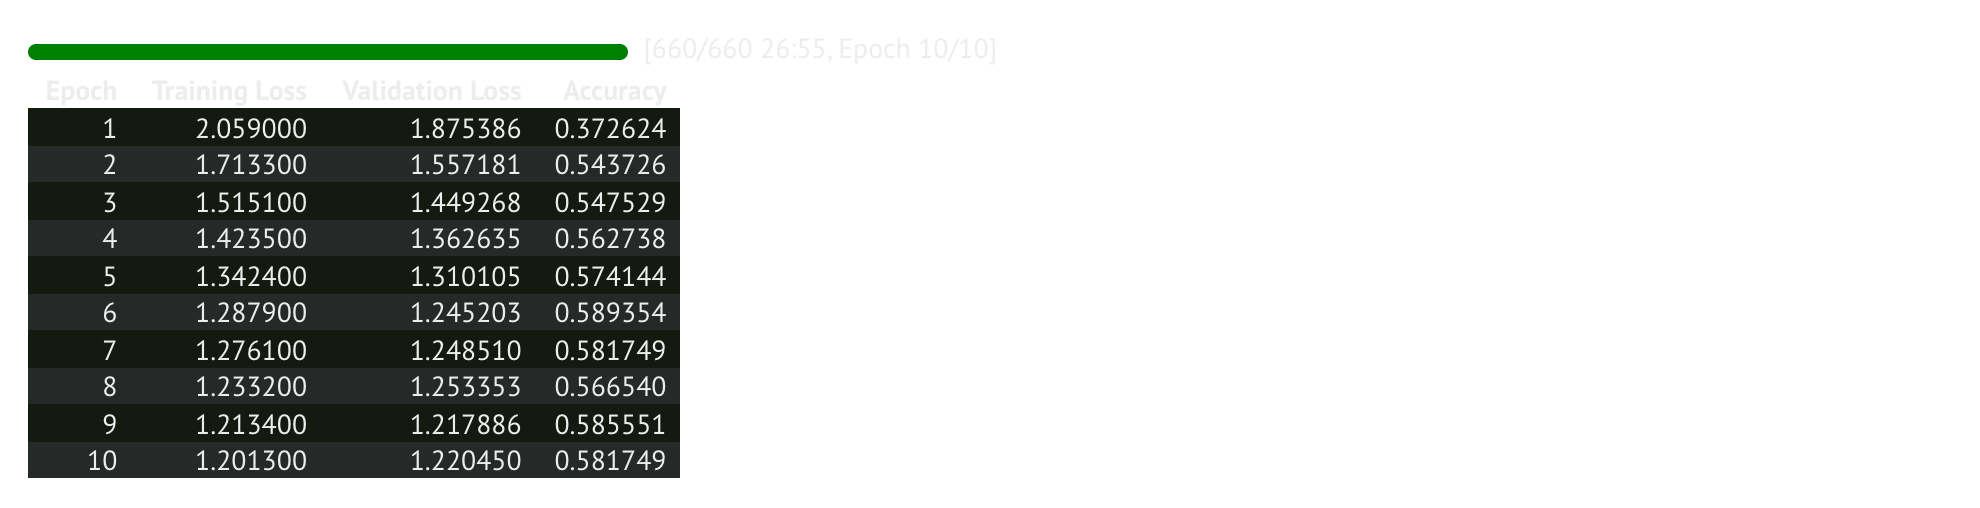

In [ ]:

# Load Model
num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label
)

# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.backends.mps.is_available():
    device = "mps"
print(f"Training on: {device}")
model.to(device)

model_name = MODEL_CHECKPOINT.split("/")[-1]
batch_size = 4 # Adjust based on memory

args = TrainingArguments(
    f"models/{model_name}-finetuned-baby-cry",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False
)



# Define datasets
train_ds = encoded_train
eval_ds = encoded_test

# Uncomment next lines to test on a small subset
# train_ds = encoded_train.select(range(10))
# eval_ds = encoded_test.select(range(10))

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    processing_class=feature_extractor,
    compute_metrics=compute_metrics
)

# Uncomment to train
train_output = trainer.train()

/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.2452032566070557, 'eval_accuracy': 0.5893536121673004, 'eval_runtime': 10.4938, 'eval_samples_per_second': 25.063, 'eval_steps_per_second': 6.289, 'epoch': 10.0}


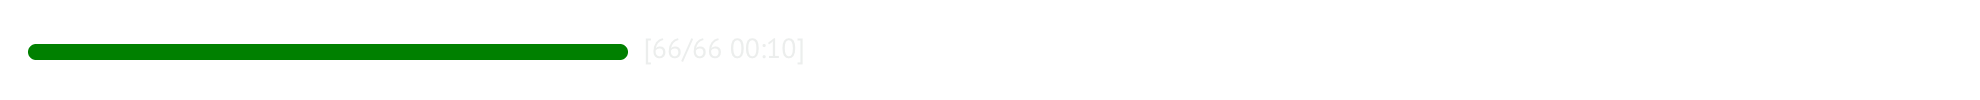

In [ ]:
# Evaluate
train_results = trainer.evaluate()
print(train_results)